<H1>Необходимо предсказать верхнюю границу заработной платы (salary_to) для вакансии</H1>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import xlrd
from itertools import chain
pd.set_option('display.max_colwidth', None)

Считываем данные для обучения:

In [2]:
#pd.options.display.max_rows = 2

df = pd.read_csv('X_train.csv', parse_dates=['published_at', 'created_at'])

#df
#df.describe()

Считываем значения salary_to для данных для обучения и мерджим с предыдущей таблицей

In [3]:
df1 = pd.read_csv('y_train.csv')
df = df.set_index('id').join(df1.set_index('id'))
#df

<H1>Исследование данных / Data exploration</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   created_at                27934 non-null  datetime64[ns, UTC]
 8   employer_name             27934 non-null  object             
 9   description               27933 non-null  object             
 10  area_id                   27934 non-null  int64              
 11  area_name       

Три колонки имеют пустоты: salary_from, salary_gross, и у 1-го нет description

In [5]:
pd.options.display.max_rows = 13
df.describe(include='O')

,name,salary_currency,salary_gross,employer_name,description,area_name
count,27934,27934,27786,27934,27933,27934
unique,16395,1,2,13318,23681,156
top,Менеджер по продажам,RUR,False,Пятёрочка,"<p><strong>Обязанности:</strong></p><ul><li>Обслуживание покупателей на кассе (наличный и безналичный расчет)</li><li>Выкладка товара в зале</li><li>Отслеживание сроков годности товара</li><li>Проверка наличия ценников</li><li>Консультация покупателей в зале</li></ul><p><strong>Требования:</strong></p><ul><li>Ответственность, дисциплинированность, внимательность</li></ul><p><strong>Условия:</strong></p><ul><li>График работы 5/2, 2/2, возможен неполный рабочий день, неполная рабочая неделя</li><li>Возможность подработки (работа по совместительству)</li><li>Социальные гарантии, оплата отпусков и больничных листов</li><li>Работа рядом с домом</li><li>Скидки в магазинах сети</li><li>Фирменная спецодежда</li><li>Возможность профессионального и карьерного роста, корпоративное обучение</li><li>Корпоративные мероприятия и конкурсы</li></ul>",Москва
freq,337,27934,18726,927,624,20512


<H1>Даты</H1>

Столбцы published_at и created_at выглядят одинаковыми, проверим

In [6]:
(df['published_at']==df['created_at']).value_counts()

True    27934
Name: count, dtype: int64

Таким образом, столбцы published_at и created_at напрямую коррелируют, значит один из них можно отбросить

In [7]:
df = df.drop(columns=['created_at'])

Разберемся с датами в published_at. Заменим даты на разницу между концом 2022 года (за который собирался dataset) и датой в published_at:

In [8]:
df['published_at_diff'] = df['published_at'].map(lambda x: x.timestamp() - datetime.timestamp(datetime(2010, 12, 31)))
#df['published_at_diff'] = df['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())
#df_one_hoted = df_one_hoted.drop(columns=['published_at'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   employer_name             27934 non-null  object             
 8   description               27933 non-null  object             
 9   area_id                   27934 non-null  int64              
 10  area_name                 27934 non-null  object             
 11  salary_to       

<H1>Количественные / Quantitative</H1>

In [10]:
import matplotlib.pyplot as plt

В salary_from есть пустые значения. Поместим туда среднее значение всего столбца:

In [11]:
#df = df.dropna(subset = ['salary_from'])
df.salary_from.fillna(df.salary_from.mean(), inplace = True) 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               27934 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   employer_name             27934 non-null  object             
 8   description               27933 non-null  object             
 9   area_id                   27934 non-null  int64              
 10  area_name                 27934 non-null  object             
 11  salary_to       

Посмотрим на распределение всех числовых величин:

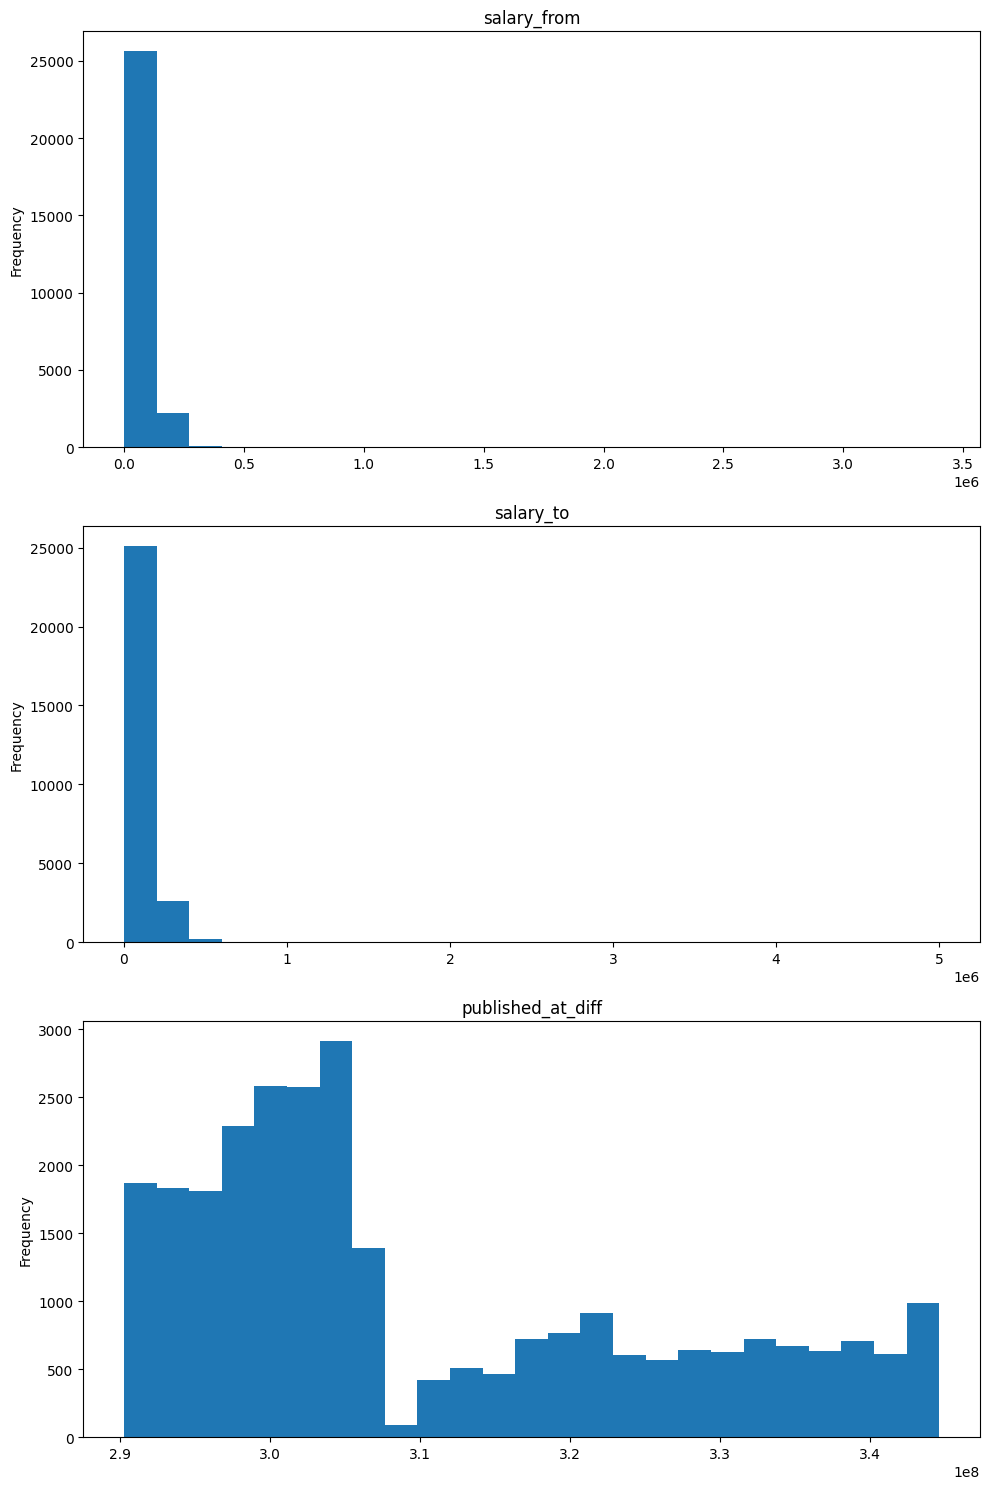

In [13]:
df_numeric = df[['salary_from', 'salary_to', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric.columns):
    df_numeric[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

Во первых, нормализуем publised_at_diff:

In [14]:
df["published_at_diff"] = df["published_at_diff"] / 1e8

In [15]:
#df['published_at_diff'] = df['published_at_diff'].map(lambda x: "Recent" if x < 5 else "Middle" if x >= 5 and x < 7 else "Old")
#df['published_at_diff1'] = df['published_at_diff'].map(lambda x: "Recent" if x <= 1.0 else "Old")

In [16]:
#df.info()

In [17]:
#df['published_at_diff'] = df['published_at_diff'].astype(object)

In [18]:
#df

Можем удалить столбец published_at:

In [19]:
df = df.drop(columns=['published_at'])
#df = df.drop(columns=['published_at', 'published_at_diff'])

<H1>Категориальные / Category</H1>

В колонке description есть много информации, в части из них есть информация о зароботной плате, которую нужно извлечь, например, в следующем тексте:

In [20]:
df['description'][20418]

'<p><strong>5 причин работать в «Улыбке радуги»</strong></p> <ol> <li>Опыт работы не требуется, мы обучаем наших сотрудников</li> <li>Вы быстро и легко освоитесь, потому что вся информация доступна и понятна</li> <li>У нас нет личных продаж, скрытых коэффициентов и штрафов</li> <li>Вы сможете выбрать магазин рядом с домом, чтобы не тратить время и деньги на дорогу</li> <li>Вы узнаете все о новинках в сфере косметики, товаров по уходу за собой и домом</li> </ol> <p> </p> <p><strong>Что вы будете делать?</strong></p> <ol> <li>Встречать покупателей в магазине, рассказывать об акциях</li> <li>Помогать покупателям в поиске и выборе товара</li> <li>Поддерживать порядок в магазине</li> </ol> <p> </p> <p><strong>Если вы:</strong></p> <ol> <li>Любите общаться с людьми</li> <li>Любознательны и инициативны</li> <li>Позитивны и готовы делиться хорошим настроением с окружающими</li> </ol> <p> </p> <p>Значит, мы ждем именно вас!</p> <p> </p> <p><strong>Мы предлагаем:</strong></p> <ol> <li>Оформление

Здесь можно извлеч 196 руб./час и преобразовать это в зарплату в месяц (примерно, 196 * 40 * 4). В других description есть зарплаты за месяц, день.

Сначала избавимся от HTML тегов:

In [21]:
import re
df['description'] = pd.Series(df['description'],dtype=pd.StringDtype())
df.description = df.description.apply(lambda x: str(x).lower())
df.description = df.description.apply(lambda x: re.sub(r'</?[A-Za-z0-9]+ ?/?>', ' ', str(x)))

Определим функцию, которая будет извлекать из строки description максимальную упомянотую зарплату. Если таковой нет, сделаем её равной 0. Также сделаем равной 0 зарплаты, которые получились меньше 1000. Такое могло произойти, если извлеченная зарплата была не той по смыслу, или была какая-то другая цена.

In [22]:
def manage_desc(string):
    #print(string)
    pattern = r'[0-9][0-9.,тыс ]+[0-9 ]руб.?\/?[а-яА-Я ]*([0-9 ]+час)?(час)?(мес)?(день)?'
    max_salary = -1
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        for ch in match:
            if ch.isnumeric():
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                pass
            else:
                if first_numeric_found:
                    break
        salary = int(number)
        if 'сут' in match or 'день' in match:
            salary *= 20
        elif 'час' in match:
            salary *= 160

        if 'тыс' in match or 'т.' in match:
            salary *= 1000
        
        if max_salary == -1 or salary > max_salary:
            max_salary = salary
    
    if (max_salary < 1000):
        return pd.NA
    else:
        return max_salary

#manage_desc(df['description'][23187])

Теперь преобразуем все description

In [23]:
df.description = df.description.map(manage_desc)
df.description.value_counts()

description
40000         354
50000         331
60000         312
30000         269
100000        256
             ... 
1000000000      1
145000          1
648000          1
34900           1
25500           1
Name: count, Length: 354, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               4800 non-null   object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


In [25]:
#df['description'] = df['description'].map(lambda x: x if x > 0 else pd.NA)

In [26]:
df.description.fillna(df.salary_from, inplace = True) 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27934 non-null  float64
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(4), int64(1), object(5)
memory usage: 3.4+ MB


In [28]:
#df.description = df.description.apply(lambda x: df.description.min() if x == -1 else x)

In [29]:
#df = df.drop(columns=['description'])

Далее, salary_currency имеет unique=1, значит эту колонку можно удалить

In [30]:
df = df.drop(columns=['salary_currency'])

In [31]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name
count,27934,27786,27934,27934
unique,16395,2,13318,156
top,Менеджер по продажам,False,Пятёрочка,Москва
freq,337,18726,927,20512


Оставшиеся 3 столбца: name, employer_name и area_name имеют достаточно много уникальных значений.

Начнем с area_name

In [32]:
#pd.options.display.max_rows = 20
df['area_name'].value_counts()

area_name
Москва                         20512
Санкт-Петербург                 5393
Новосибирск                      201
Краснодар                        178
Екатеринбург                     158
                               ...  
Каменск-Шахтинский                 1
Стерлитамак                        1
Турция                             1
Донецк (Ростовская область)        1
Курган                             1
Name: count, Length: 156, dtype: int64

Во первых, в таблице есть area_id, которая является альтернативным представлением городов. Удалим его:

In [33]:
#df['area_id'].value_counts()

In [34]:
df = df.drop(columns=['area_id'])

Далее, выделим несколько часто встречающихся городов, остальные заменим Other:

In [35]:
df.loc[df["area_name"].value_counts()[df["area_name"]].values < 200, "area_name"] = "Other"
df['area_name'].value_counts()

area_name
Москва             20512
Санкт-Петербург     5393
Other               1828
Новосибирск          201
Name: count, dtype: int64

Далее посмотрим на employer_name

In [36]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    927
Пятерочка                    669
Перекресток                  324
Билайн                       261
JCat.ru                       70
                            ... 
Торговая группа ПТК            1
LTG Consulting                 1
ExMail                         1
Албаков Руслан Борисович       1
Балтик Граунд Сервисес РУ      1
Name: count, Length: 13318, dtype: int64

Во первых, можно увидеть два разных написания "Пятерочка", оставим одно:

In [37]:
df = df.replace(to_replace ="Пятерочка", value ="Пятёрочка") 

df.employer_name.unique()

array(['Villagio Estate', 'CityAds Media', 'Лендсбэй', ...,
       'Харчевников Александр Андреевич', 'RedStone Capital',
       'Балтик Граунд Сервисес РУ'], dtype=object)

In [38]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    1596
Перекресток                   324
Билайн                        261
JCat.ru                        70
Skyeng                         63
                             ... 
Торговая группа ПТК             1
LTG Consulting                  1
ExMail                          1
Албаков Руслан Борисович        1
Балтик Граунд Сервисес РУ       1
Name: count, Length: 13317, dtype: int64

Далее, изменим у всех строки в нижний регистр:

In [39]:
df.employer_name = df.employer_name.apply(lambda x: x.lower())

В списке employer_name есть ИП, либо написанные как ФИО, либо напрямую упоминающие аббревиатуру ИП. Заменим их всех на категорию "personname"

In [40]:
df.employer_name = df.employer_name.apply(lambda x: "personname" if (x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') or x.startswith('ип') or '(ип ' in x) else x)
df['employer_name'].value_counts()

employer_name
personname                   1755
пятёрочка                    1596
перекресток                   324
билайн                        261
jcat.ru                        70
                             ... 
belmont                         1
y@mmymammy                      1
дпо аудит                       1
глори                           1
балтик граунд сервисес ру       1
Name: count, Length: 11983, dtype: int64

In [41]:
#f = open("emplyer_name.txt", "w")
#np.savetxt("employer_name7.txt", df.employer_name.unique(), fmt='%s');
#f.write()
#f.close()
#df['employer_name'].value_counts()

Выделим также, как и с area_name, первые несколько, а другие заменим на Other:

In [42]:
df.loc[df["employer_name"].value_counts()[df["employer_name"]].values < 100, "employer_name"] = "Other"
df['employer_name'].value_counts()

employer_name
Other          23998
personname      1755
пятёрочка       1596
перекресток      324
билайн           261
Name: count, dtype: int64

Теперь рассмотрим последний столбец: name

In [43]:
df['name'].value_counts()

name
Менеджер по продажам                                   337
Менеджер по работе с клиентами                         201
Юрист                                                  162
Помощник юриста                                        149
Аналитик                                               145
                                                      ... 
Бизнес-аналитик(Внедренец/ Ведущий бизнес-аналитик)      1
Руководитель департамента коммерческой недвижимости      1
Логист- оператор / Грузчик (ТРК Европолис)               1
User Acquisition Manager                                 1
Копирайтер / контент менеджер                            1
Name: count, Length: 16395, dtype: int64

Можно увидеть перечисления через /, либо доп. указания в скобках. Сначала преобразуем всё к нижнему регистру:

In [44]:
df.name = df.name.apply(lambda x: x.lower())

Далее, выполним преобразования над названиями, заменяя их на ключевые слова:

In [45]:

df.name = df.name.apply(lambda x: 'маркетолог' if ('маркетолог' in x or 'market' in x or 'реклам' in x or 'таргетолог' in x or 'промоутер' in x or 'таркетолог' in x) else x)
df.name = df.name.apply(lambda x: 'менеджер' if ('менеджер' in x or 'manager' in x or 'manager' in x) else x)
df.name = df.name.apply(lambda x: 'бухгалтер' if ('бухгалтер' in x) else x)
df.name = df.name.apply(lambda x: 'юрист' if ('юрист' in x) else x)
df.name = df.name.apply(lambda x: 'директор' if ('директор' in x) else x)
df.name = df.name.apply(lambda x: 'разработчик' if ('разраб' in x or 'программист' in x or 'програмист' in x or 'dev' in x or 'backend' in x or 'frontend' in x or 'back-end' in x or 'front-end' in x or 'senior' in x or 'middle' in x or 'junior' in x or 'lead' in x or 'data' in x or 'верст' in x or 'architect' in x) else x)
df.name = df.name.apply(lambda x: 'продавец' if ('продавец' in x or 'кассир' in x) else x)
df.name = df.name.apply(lambda x: 'администратор' if ('администратор' in x) else x)
df.name = df.name.apply(lambda x: 'дизайнер' if ('дизайн' in x or 'design' in x or 'художник' in x or 'artist' in x) else x)
df.name = df.name.apply(lambda x: 'инженер' if ('инженер' in x or 'engineer' in x or 'инжинер' in x) else x)
df.name = df.name.apply(lambda x: 'аналитик' if ('аналитик' in x or 'analyst' in x) else x)
df.name = df.name.apply(lambda x: 'технолог' if ('технолог ' in x) else x)
df.name = df.name.apply(lambda x: 'райтер' if ('копирайтер' in x or 'перевод' in x or 'translat' in x or 'автор' in x or 'райтер' in x or 'редактор' in x or 'писатель' in x) else x)
df.name = df.name.apply(lambda x: 'медик' if ('врач' in x or 'фармацевт' in x or 'провизор' in x or 'химик' in x or 'биолог' in x or 'медиц' in x or 'стомат' in x or 'терапевт' in x or 'хирург' in x or 'медс' in x or 'психолог' in x) else x)
df.name = df.name.apply(lambda x: 'руководитель' if ('руковод' in x) else x)
df.name = df.name.apply(lambda x: 'hr' if ('hr' in x or 'рекрутер' in x or 'сорсер' in x or 'ресерчер' in x or 'кадровик' in x or 'эйчар' in x or 'интервьюер' in x or 'recruit' in x or 'researcher' in x or 'ресечер' in x) else x)
df.name = df.name.apply(lambda x: 'консультант' if ('консульт' in x) else x)
df.name = df.name.apply(lambda x: 'оператор' if ('оператор' in x) else x)
df.name = df.name.apply(lambda x: 'пекарь' if ('пекарь' in x) else x)
df.name = df.name.apply(lambda x: 'стилист' if ('стилист' in x or 'парик' in x or 'барбер' in x or 'маникюр' in x or 'педикюр' in x or 'косметолог' in x or 'визажист' in x) else x)
df.name = df.name.apply(lambda x: 'уборщик' if ('уборщик' in x or 'уборщица' in x) else x)
df.name = df.name.apply(lambda x: 'курьер' if ('курьер' in x) else x)
df.name = df.name.apply(lambda x: 'управляющий' if ('управляющ' in x or 'заведующ' in x) else x)
df.name = df.name.apply(lambda x: 'водитель' if (' водитель' in x or x.startswith('водитель')) else x)
df.name = df.name.apply(lambda x: 'учитель' if ('учитель' in x or 'препод' in x or 'педагог' in x or 'тьютор' in x or 'воспит' in x or 'репетитор' in x or 'тренер' in x) else x)
df.name = df.name.apply(lambda x: 'координатор' if ('координатор' in x or 'coordinator' in x) else x)
df.name = df.name.apply(lambda x: 'повар' if ('повар' in x or 'шеф' in x or 'пекарь' in x or 'кух' in x or 'кондитер' in x) else x)
df.name = df.name.apply(lambda x: 'бармен' if ('бар' in x) else x)
df.name = df.name.apply(lambda x: 'официант' if ('офици' in x) else x)
df.name = df.name.apply(lambda x: 'qa' if (' qa' in x or x.startswith('qa') or 'тест' in x or 'качеств' in x) else x)
df.name = df.name.apply(lambda x: 'монтажер' if ('монтаж' in x or 'видео' in x) else x)
df.name = df.name.apply(lambda x: 'фотограф' if ('фото' in x) else x)
df.name = df.name.apply(lambda x: 'охрана' if ('охран' in x) else x)
df.name = df.name.apply(lambda x: 'экономист' if ('эконом' in x) else x)
df.name = df.name.apply(lambda x: 'мерчендайзер' if ('мерчендайзер' in x or 'мерчандайзер' in x) else x)
df.name = df.name.apply(lambda x: 'сварщик' if ('сварщик' in x) else x)
df.name = df.name.apply(lambda x: 'слесарь' if ('слесарь' in x or 'механик' in x or 'токарь' in x) else x)
df.name = df.name.apply(lambda x: 'грузчик' if ('грузчик' in x or 'кладов' in x or 'склад' in x or 'комплектовщик' in x) else x)
df.name = df.name.apply(lambda x: 'отделочник' if ('отдело' in x) else x)
df.name = df.name.apply(lambda x: 'аренда' if ('аренд' in x) else x)
df.name = df.name.apply(lambda x: 'стажер' if ('стажер' in x or 'стажёр' in x) else x)
df.name = df.name.apply(lambda x: 'товаровед' if ('товар' in x) else x)
df.name = df.name.apply(lambda x: 'домработник' if ('домраб' in x or 'горнич' in x) else x)
df.name = df.name.apply(lambda x: 'недвижимость' if ('недвиж' in x) else x)
df.name = df.name.apply(lambda x: 'сборщик' if ('сбор' in x) else x)
df.name = df.name.apply(lambda x: 'логист' if ('секрет' in x or 'логист' in x or 'диспетч' in x) else x)
df.name = df.name.apply(lambda x: 'мойщик' if ('мой' in x or 'детейл' in x) else x)
df.name = df.name.apply(lambda x: 'мастер' if ('мастер' in x) else x)
df.name = df.name.apply(lambda x: 'специалист' if ('специалист' in x) else x)
df.name = df.name.apply(lambda x: 'ассистент' if ('ассистент' in x) else x)
df.name = df.name.apply(lambda x: 'архитектор' if ('архитек' in x or 'конструкт' in x) else x)
df.name = df.name.apply(lambda x: 'начальник' if ('начальн' in x) else x)
df.name = df.name.apply(lambda x: 'полиция' if ('полиц' in x or ' след' in x or x.startswith('след') or 'дпс' in x or 'мвд' in x or 'оперу' in x) else x)
df.name = df.name.apply(lambda x: 'представитель' if ('представитель' in x) else x)
df.name = df.name.apply(lambda x: 'техник' if ('техник' in x) else x)
df.name = df.name.apply(lambda x: 'сотрудник' if ('сотрудник' in x) else x)
df.name = df.name.apply(lambda x: 'упаковщик' if ('упаков' in x or 'фасов' in x) else x)
df.name = df.name.apply(lambda x: 'агент' if ('агент' in x) else x)
df['name'].value_counts()

name
разработчик                       5330
менеджер                          4979
продавец                          2209
инженер                           1220
аналитик                           936
                                  ... 
помощник/помощница на даче           1
маляр по дереву                      1
обивщик мебели, распиловщик          1
treasury associate                   1
ученик на швейное производство       1
Name: count, Length: 835, dtype: int64

In [46]:
#np.savetxt("name1.txt", df['name'].value_counts(), fmt='%s');

Выбрав определенную границу, заменим остальные на Other:

In [47]:
df.loc[df["name"].value_counts()[df["name"]].values < 100, "name"] = "Other"
df['name'].value_counts()

name
разработчик     5330
менеджер        4979
Other           2488
продавец        2209
инженер         1220
                ... 
мастер           116
полиция          111
ассистент        111
слесарь          106
мерчендайзер     101
Name: count, Length: 34, dtype: int64

In [48]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name
count,27934,27786,27934,27934
unique,34,2,5,4
top,разработчик,False,Other,Москва
freq,5330,18726,23998,20512


Для salary_gross нужно заполнить пропуски и преобразовать из типа object в тип bool: 

In [49]:
df.salary_gross.fillna(False, inplace = True) 
df['salary_gross'] = df['salary_gross'].astype(bool)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27934 non-null  float64
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(4), object(3)
memory usage: 2.8+ MB


<H1>One-Hotting</H1>

Сделаем one-hotting категориальных фич:

In [51]:
df_one_hoted = df.copy()

#ONE_HOT_COL = ['area_name', 'name', 'employer_name', 'published_at_diff']
ONE_HOT_COL = ['area_name', 'name', 'employer_name']

temp = pd.get_dummies(df_one_hoted[ONE_HOT_COL], prefix=ONE_HOT_COL, dtype=bool)

df_one_hoted = pd.concat([temp, df], axis=1)

df_one_hoted.head()

,area_name_Other,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,name_Other,name_hr,name_администратор,name_аналитик,name_ассистент,name_бухгалтер,...,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,salary_to,published_at_diff
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,менеджер,False,False,64179.458874,False,Other,64179.458874,Москва,200000.0,2.985363
26052,False,True,False,False,False,False,False,False,False,False,...,маркетолог,False,False,120000.000000,False,Other,120000.000000,Москва,170000.0,3.016599
24055,False,True,False,False,False,False,False,False,False,False,...,разработчик,False,False,64179.458874,False,Other,64179.458874,Москва,120000.0,2.929259
4408,False,True,False,False,False,False,False,False,False,False,...,продавец,False,False,33500.000000,True,пятёрочка,33500.000000,Москва,38000.0,3.044782
16856,False,True,False,False,False,False,False,False,False,False,...,дизайнер,False,True,30000.000000,True,Other,30000.000000,Москва,35000.0,3.382182


Удалим столбцы:

In [52]:
df_one_hoted = df_one_hoted.drop(columns=['employer_name', 'name', 'area_name'])
#df_one_hoted = df_one_hoted.drop(columns=['employer_name', 'name', 'area_name', 'published_at_diff'])

In [53]:
df_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_name_Other            27934 non-null  bool   
 1   area_name_Москва           27934 non-null  bool   
 2   area_name_Новосибирск      27934 non-null  bool   
 3   area_name_Санкт-Петербург  27934 non-null  bool   
 4   name_Other                 27934 non-null  bool   
 5   name_hr                    27934 non-null  bool   
 6   name_администратор         27934 non-null  bool   
 7   name_аналитик              27934 non-null  bool   
 8   name_ассистент             27934 non-null  bool   
 9   name_бухгалтер             27934 non-null  bool   
 10  name_водитель              27934 non-null  bool   
 11  name_грузчик               27934 non-null  bool   
 12  name_дизайнер              27934 non-null  bool   
 13  name_директор              27934 non-null  bool

In [54]:
df = df_one_hoted

<H1>Корреляция</H1>

In [55]:
df.corr().style.background_gradient(cmap='coolwarm')

,area_name_Other,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,name_Other,name_hr,name_администратор,name_аналитик,name_ассистент,name_бухгалтер,name_водитель,name_грузчик,name_дизайнер,name_директор,name_инженер,name_консультант,name_курьер,name_логист,name_маркетолог,name_мастер,name_медик,name_менеджер,name_мерчендайзер,name_монтажер,name_оператор,name_охрана,name_повар,name_полиция,name_продавец,name_разработчик,name_райтер,name_руководитель,name_слесарь,name_специалист,name_стажер,name_уборщик,name_учитель,name_юрист,employer_name_Other,employer_name_personname,employer_name_билайн,employer_name_перекресток,employer_name_пятёрочка,has_test,response_letter_required,salary_from,salary_gross,description,salary_to,published_at_diff
area_name_Other,1.000000,-0.439908,-0.022528,-0.129433,-0.056317,0.092669,0.009416,-0.000203,-0.012112,0.021084,-0.025649,-0.031569,0.079845,-0.026481,-0.049466,-0.016539,-0.026482,-0.013427,-0.027395,-0.017088,-0.029041,-0.032084,-0.015940,-0.024634,-0.009840,-0.023305,-0.025748,-0.016714,-0.077006,0.202327,-0.026417,-0.028886,-0.016332,-0.004929,-0.000331,-0.040261,0.062727,-0.039689,0.060151,-0.002892,-0.021185,-0.028665,-0.065139,0.025561,0.008134,0.023217,-0.032124,-0.003217,0.025690,0.277148
area_name_Москва,-0.439908,1.000000,-0.141528,-0.813153,-0.009089,-0.038530,-0.005649,0.062463,0.014805,-0.015661,-0.018499,-0.021254,-0.043994,0.053876,0.061132,0.026641,-0.036318,-0.018960,0.043175,0.002295,0.003714,0.036405,-0.016426,0.013846,0.010995,-0.094477,-0.003689,-0.000654,-0.027051,-0.109901,0.043813,0.013107,-0.006375,0.003229,0.003375,0.064269,-0.005017,0.077600,-0.006473,0.010120,-0.029192,-0.030213,0.025160,-0.001626,0.006627,0.063912,0.004193,0.002129,0.043771,-0.046759
area_name_Новосибирск,-0.022528,-0.141528,1.000000,-0.041642,-0.019186,0.028063,-0.002342,-0.011144,-0.005377,0.000278,-0.008252,-0.010157,0.041891,-0.006010,-0.011976,-0.007463,-0.008520,-0.006701,-0.003920,-0.005498,-0.009755,-0.023049,-0.005128,-0.007925,-0.013088,-0.007498,-0.008284,-0.005377,-0.024947,0.097710,-0.011052,-0.012527,-0.005254,-0.008766,-0.002709,-0.012953,-0.002724,-0.013376,0.019869,-0.001096,-0.008268,-0.009222,-0.020957,0.021338,0.000391,0.030389,-0.028221,-0.001285,0.028871,0.087477
area_name_Санкт-Петербург,-0.129433,-0.813153,-0.041642,1.000000,0.049565,-0.020952,0.000923,-0.067387,-0.007828,0.004257,0.038540,0.045739,-0.009764,-0.042414,-0.034854,-0.017852,0.059060,0.031065,-0.030312,0.009315,0.016128,-0.015702,0.029467,0.001636,-0.003337,0.121936,0.022035,0.012355,0.083863,-0.024703,-0.030112,0.006113,0.018492,0.001352,-0.002990,-0.043924,-0.033103,-0.059109,-0.034699,-0.009279,0.047712,0.053746,0.017144,-0.018765,-0.012597,-0.092577,0.021478,-0.000092,-0.071262,-0.140052
name_Other,-0.056317,-0.009089,-0.019186,0.049565,1.000000,-0.041170,-0.054549,-0.058222,-0.019750,-0.037974,-0.030309,-0.037304,-0.040684,-0.035829,-0.066823,-0.027409,-0.031293,-0.024612,-0.046485,-0.020192,-0.035829,-0.145629,-0.018836,-0.029109,-0.048073,-0.027539,-0.030426,-0.019750,-0.091630,-0.151840,-0.040595,-0.046011,-0.019299,-0.058158,-0.027668,-0.047575,-0.043902,-0.049131,0.018267,0.026771,-0.030367,0.033033,-0.058021,-0.023982,-0.011578,-0.065352,-0.014752,-0.004319,-0.041078,-0.142571
name_hr,0.092669,-0.038530,0.028063,-0.020952,-0.041170,1.000000,-0.022969,-0.024516,-0.008316,-0.015990,-0.012762,-0.015708,-0.017131,-0.015087,-0.028137,-0.011541,-0.013177,-0.010364,-0.019573,-0.008502,-0.015087,-0.061320,-0.007931,-0.012257,-0.020242,-0.011596,-0.012811,-0.008316,-0.038582,-0.063935,-0.017093,-0.019374,-0.008126,-0.024488,-0.011650,-0.020032,-0.018486,-0.020687,0.023906,0.008087,-0.012787,-0.014263,-0.032411,0.006961,0.026428,-0.016605,-0.036271,-0.002039,0.001442,0.114188
name_администратор,0.009416,-0.005649,-0.002342,0.000923,-0.054549,-0.022969,1.000000,-0.032482,-0.011019,-0.021186,-0.016909,-0.020812,-0.022697,-0.019989,-0.037280,-0.015292,-0.017459,-0.013731,-0.025934,-0.011265,-0.01998

<H1>Создание модели</H1>

In [56]:
from sklearn.model_selection import train_test_split


#df_sampled = df.sample(20_000)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='salary_to'), df.salary_to, test_size=0.2)

In [57]:
#df_sampled.info()

In [58]:
df.salary_to.describe()

count    2.793400e+04
mean     1.044182e+05
std      1.052993e+05
min      1.000000e+01
25%      4.500000e+04
50%      7.000000e+04
75%      1.400000e+05
max      5.000000e+06
Name: salary_to, dtype: float64

In [59]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [60]:
%%time
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 32.15069007045269, SMAPE test: 31.54467183041093
CPU times: user 389 ms, sys: 1.15 s, total: 1.54 s
Wall time: 423 ms


In [61]:
model_SGR = SGDRegressor() # epsilon_insensitive, huber, squared_loss
model_SGR.fit(X_train, y_train)

y_pred_train = model_SGR.predict(X_train)
y_pred_test = model_SGR.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 200.0, SMAPE test: 200.0


In [62]:
%%time
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


xg_model = XGBRegressor(n_estimators  = 10)
xg_model.fit(X_train, y_train)

y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 28.79344700784137, SMAPE test: 28.741616539650202
CPU times: user 4.22 s, sys: 185 ms, total: 4.41 s
Wall time: 1.21 s


In [63]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


model = RandomForestRegressor(n_estimators=100, min_samples_split=4, max_depth=30)#criterion='friedman_mse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 14.30098491900973, SMAPE test: 25.415295912071183
CPU times: user 17.1 s, sys: 58.4 ms, total: 17.2 s
Wall time: 18.7 s


In [64]:
model.score(X_test, y_test)

0.5569941757056216

In [65]:
importances = dict(zip(model.feature_names_in_, model.feature_importances_))
importances = {k: v for k,v in sorted(importances.items(), key=lambda x: x[1], reverse=True)}

In [66]:
importances

{'salary_from': 0.49211781270652044,
 'published_at_diff': 0.29583881071816753,
 'description': 0.10228270987866724,
 'name_разработчик': 0.017939837691700787,
 'name_Other': 0.016987507940462363,
 'salary_gross': 0.01008375727045952,
 'name_менеджер': 0.008590474082443548,
 'area_name_Санкт-Петербург': 0.007794327539472391,
 'area_name_Москва': 0.0046555384757961836,
 'response_letter_required': 0.0045828523562305495,
 'employer_name_personname': 0.004193630403514592,
 'name_директор': 0.0036288520224257554,
 'name_специалист': 0.003497037833532499,
 'name_медик': 0.003193013026486211,
 'employer_name_Other': 0.0030449314782541536,
 'has_test': 0.0028373019402000337,
 'name_руководитель': 0.0028009224624543395,
 'area_name_Other': 0.0020197966348967176,
 'name_аналитик': 0.0018076660420113452,
 'name_консультант': 0.0017738094015340533,
 'name_маркетолог': 0.0016086935656912573,
 'name_hr': 0.0010387911713955111,
 'name_инженер': 0.001002005244975541,
 'name_юрист': 0.0009271760798779

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 30, 50, None],
    'min_samples_split': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid, verbose=10)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

In [ ]:
model.score(X_test, y_test)

In [ ]:
%%time
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


#model = RandomForestRegressor(n_estimators=100)#criterion='friedman_mse')
#model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

<H1>Тестовая дата</H1>

Загрузим тестовую таблицу:

In [67]:
df_test = pd.read_csv('X_test.csv', parse_dates=['published_at', 'created_at'])

Сразу уберем столбцы salary_currency (одно и то же значение), created_at (совпадает с published_at) и area_id (аналогично area_name):

In [68]:
df_test = df_test.drop(columns=['salary_currency', 'created_at', 'area_id'])

In [69]:
df_test = df_test.set_index('id')

Заполняем salary_gross, если есть пропуски:

In [70]:
df_test.salary_gross.fillna(False, inplace = True) 
df_test['salary_gross'] = df_test['salary_gross'].astype(bool)
#df_test['salary_gross'] = df_test['salary_gross'].astype(bool)

Заполняем пустые salary_from средним значением:

In [71]:
df_test.salary_from.fillna(df_test.salary_from.mean(), inplace = True) 

Преобразуем published_at, как и с обучаемым dataset:

In [72]:
df_test['published_at_diff'] = df_test['published_at'].map(lambda x: x.timestamp() - datetime.timestamp(datetime(2010, 12, 31)))
#df['published_at_diff'] = df['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())
#df_one_hoted = df_one_hoted.drop(columns=['published_at'])
#df_test['published_at_diff'] = df_test['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())
#df_one_hoted = df_one_hoted.drop(columns=['published_at'])
df_test["published_at_diff"] = df_test["published_at_diff"] / 1e8
#df_test['published_at_diff1'] = df_test['published_at_diff'].map(lambda x: "Recent" if x <= 1.0 else "Old")
df_test = df_test.drop(columns=['published_at'])
#df_test = df_test.drop(columns=['published_at', 'published_at_diff'])

Преобразуем description:

In [73]:
df_test.description = df_test.description.map(manage_desc)
#df_test.description = df_test.description.apply(lambda x: df_test.description.min() if x == -1 else x)
df_test.description.value_counts()

description
40000         126
60000         107
50000          91
30000          85
100000         81
             ... 
1375            1
92400           1
1500030000      1
52800           1
1600000         1
Name: count, Length: 211, dtype: int64

In [74]:
#df_test['published_at_diff'] = df_test['published_at'].map(lambda x: x if x > 0 else pd.NA)
df_test.description.fillna(df_test.salary_from, inplace = True) 

Для area_name, оставим название, если в обучаемом dataset есть столбец, иначе заменяем на Other:

In [75]:
df_test['area_name'] = df_test['area_name'].map(lambda x: x if ('area_name_' + x) in df.columns else "Other")
#df_test.loc[df_test["area_name"].value_counts()[df_test["area_name"]].values < 200, "area_name"] = "Other"

In [76]:
df_test.area_name.value_counts()

area_name
Москва             6754
Санкт-Петербург    1877
Other               610
Новосибирск          71
Name: count, dtype: int64

Преобразуем employer_name к нижнему регистру, заменим две разные "Пяторочки" одной, всех ИП на personname, как в случае с обучаемым dataset, затем выполним ту же процедуру, что и с area_name:

In [77]:
df_test.employer_name = df_test.employer_name.apply(lambda x: x.lower())

In [78]:
df_test = df_test.replace(to_replace ="пятерочка", value ="пятёрочка") 
df_test.employer_name = df_test.employer_name.apply(lambda x: "personname" if (x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') or x.startswith('ип') or '(ип ' in x) else x)
df_test['employer_name'].value_counts()

employer_name
personname                              576
пятёрочка                               521
перекресток                             102
билайн                                   88
skyeng                                   30
                                       ... 
флористический салон цветы и чувства      1
беседа                                    1
брок-инвест-сервис                        1
солярис промо продакшн                    1
soft personal                             1
Name: count, Length: 5501, dtype: int64

In [79]:
df_test['employer_name'] = df_test['employer_name'].map(lambda x: x if ('employer_name_' + x) in df.columns else "Other")
#df_test.loc[df_test["employer_name"].value_counts()[df_test["employer_name"]].values < 100, "employer_name"] = "Other"

In [80]:
df_test.employer_name.value_counts()

employer_name
Other          8025
personname      576
пятёрочка       521
перекресток     102
билайн           88
Name: count, dtype: int64

Ту же процедуру проделываем с name:

In [81]:
df_test.name = df_test.name.apply(lambda x: x.lower())

In [82]:
df_test.name = df_test.name.apply(lambda x: 'маркетолог' if ('маркетолог' in x or 'market' in x or 'реклам' in x or 'таргетолог' in x or 'промоутер' in x or 'таркетолог' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'менеджер' if ('менеджер' in x or 'manager' in x or 'manager' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'бухгалтер' if ('бухгалтер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'юрист' if ('юрист' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'директор' if ('директор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'разработчик' if ('разраб' in x or 'программист' in x or 'програмист' in x or 'dev' in x or 'backend' in x or 'frontend' in x or 'back-end' in x or 'front-end' in x or 'senior' in x or 'middle' in x or 'junior' in x or 'lead' in x or 'data' in x or 'верст' in x or 'architect' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'продавец' if ('продавец' in x or 'кассир' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'администратор' if ('администратор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'дизайнер' if ('дизайн' in x or 'design' in x or 'художник' in x or 'artist' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'инженер' if ('инженер' in x or 'engineer' in x or 'инжинер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'аналитик' if ('аналитик' in x or 'analyst' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'технолог' if ('технолог ' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'райтер' if ('копирайтер' in x or 'перевод' in x or 'translat' in x or 'автор' in x or 'райтер' in x or 'редактор' in x or 'писатель' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'медик' if ('врач' in x or 'фармацевт' in x or 'провизор' in x or 'химик' in x or 'биолог' in x or 'медиц' in x or 'стомат' in x or 'терапевт' in x or 'хирург' in x or 'медс' in x or 'психолог' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'руководитель' if ('руковод' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'hr' if ('hr' in x or 'рекрутер' in x or 'сорсер' in x or 'ресерчер' in x or 'кадровик' in x or 'эйчар' in x or 'интервьюер' in x or 'recruit' in x or 'researcher' in x or 'ресечер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'консультант' if ('консульт' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'оператор' if ('оператор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'пекарь' if ('пекарь' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'стилист' if ('стилист' in x or 'парик' in x or 'барбер' in x or 'маникюр' in x or 'педикюр' in x or 'косметолог' in x or 'визажист' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'уборщик' if ('уборщик' in x or 'уборщица' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'курьер' if ('курьер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'управляющий' if ('управляющ' in x or 'заведующ' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'водитель' if (' водитель' in x or x.startswith('водитель')) else x)
df_test.name = df_test.name.apply(lambda x: 'учитель' if ('учитель' in x or 'препод' in x or 'педагог' in x or 'тьютор' in x or 'воспит' in x or 'репетитор' in x or 'тренер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'координатор' if ('координатор' in x or 'coordinator' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'повар' if ('повар' in x or 'шеф' in x or 'пекарь' in x or 'кух' in x or 'кондитер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'бармен' if ('бар' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'официант' if ('офици' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'qa' if (' qa' in x or x.startswith('qa') or 'тест' in x or 'качеств' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'монтажер' if ('монтаж' in x or 'видео' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'фотограф' if ('фото' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'охрана' if ('охран' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'экономист' if ('эконом' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'мерчендайзер' if ('мерчендайзер' in x or 'мерчандайзер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'сварщик' if ('сварщик' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'слесарь' if ('слесарь' in x or 'механик' in x or 'токарь' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'грузчик' if ('грузчик' in x or 'кладов' in x or 'склад' in x or 'комплектовщик' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'отделочник' if ('отдело' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'аренда' if ('аренд' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'стажер' if ('стажер' in x or 'стажёр' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'товаровед' if ('товар' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'домработник' if ('домраб' in x or 'горнич' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'недвижимость' if ('недвиж' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'сборщик' if ('сбор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'логист' if ('секрет' in x or 'логист' in x or 'диспетч' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'мойщик' if ('мой' in x or 'детейл' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'мастер' if ('мастер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'специалист' if ('специалист' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'ассистент' if ('ассистент' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'архитектор' if ('архитек' in x or 'конструкт' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'начальник' if ('начальн' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'полиция' if ('полиц' in x or ' след' in x or x.startswith('след') or 'дпс' in x or 'мвд' in x or 'оперу' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'представитель' if ('представитель' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'техник' if ('техник' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'сотрудник' if ('сотрудник' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'упаковщик' if ('упаков' in x or 'фасов' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'агент' if ('агент' in x) else x)
df_test['name'].value_counts()

name
разработчик                 1713
менеджер                    1693
продавец                     705
инженер                      405
аналитик                     319
                            ... 
аудитор бизнес-процессов       1
аудитор                        1
методист                       1
бизнес-журналист               1
обходчик объекта               1
Name: count, Length: 397, dtype: int64

In [83]:
df_test['name'] = df_test['name'].map(lambda x: x if ('name_' + x) in df.columns else "Other")
#df_test.loc[df_test["name"].value_counts()[df_test["name"]].values < 100, "name"] = "Other"

In [84]:
df_test['name'].value_counts()

name
разработчик     1713
менеджер        1693
Other            886
продавец         705
инженер          405
                ... 
логист            53
мерчендайзер      48
мастер            44
слесарь           31
полиция           31
Name: count, Length: 34, dtype: int64

Делаем one-hotting категориальных фич:

In [85]:
df_one_hoted_test = df_test.copy()

ONE_HOT_COL_TEST = ['area_name', 'name', 'employer_name']#, 'published_at_diff1']

temp_test = pd.get_dummies(df_one_hoted_test[ONE_HOT_COL_TEST], prefix=ONE_HOT_COL_TEST, dtype=bool)

df_one_hoted_test = pd.concat([temp_test, df_test], axis=1)

In [86]:
df_one_hoted_test = df_one_hoted_test.drop(columns=['employer_name', 'area_name', 'name'])#, 'published_at_diff1'])

In [87]:
df_test = df_one_hoted_test

In [88]:
#df_test['published_at'] = df_test['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())

Проверим, что все столбцы, которые есть в обучаемом dataset, есть и в тестовом dataset:

In [89]:
for columnName in df_test.columns:
    print(columnName)

area_name_Other
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
name_Other
name_hr
name_администратор
name_аналитик
name_ассистент
name_бухгалтер
name_водитель
name_грузчик
name_дизайнер
name_директор
name_инженер
name_консультант
name_курьер
name_логист
name_маркетолог
name_мастер
name_медик
name_менеджер
name_мерчендайзер
name_монтажер
name_оператор
name_охрана
name_повар
name_полиция
name_продавец
name_разработчик
name_райтер
name_руководитель
name_слесарь
name_специалист
name_стажер
name_уборщик
name_учитель
name_юрист
employer_name_Other
employer_name_personname
employer_name_билайн
employer_name_перекресток
employer_name_пятёрочка
has_test
response_letter_required
salary_from
salary_gross
description
published_at_diff


In [90]:
for columnName in df.columns:
    print(columnName)
    if not (columnName in df_test.columns) and (columnName != 'salary_to'):
        df_test[columnName] = [False] * df_test.shape[0]

area_name_Other
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
name_Other
name_hr
name_администратор
name_аналитик
name_ассистент
name_бухгалтер
name_водитель
name_грузчик
name_дизайнер
name_директор
name_инженер
name_консультант
name_курьер
name_логист
name_маркетолог
name_мастер
name_медик
name_менеджер
name_мерчендайзер
name_монтажер
name_оператор
name_охрана
name_повар
name_полиция
name_продавец
name_разработчик
name_райтер
name_руководитель
name_слесарь
name_специалист
name_стажер
name_уборщик
name_учитель
name_юрист
employer_name_Other
employer_name_personname
employer_name_билайн
employer_name_перекресток
employer_name_пятёрочка
has_test
response_letter_required
salary_from
salary_gross
description
salary_to
published_at_diff


In [91]:
df_test.columns

Index(['area_name_Other', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'name_Other', 'name_hr',
       'name_администратор', 'name_аналитик', 'name_ассистент',
       'name_бухгалтер', 'name_водитель', 'name_грузчик', 'name_дизайнер',
       'name_директор', 'name_инженер', 'name_консультант', 'name_курьер',
       'name_логист', 'name_маркетолог', 'name_мастер', 'name_медик',
       'name_менеджер', 'name_мерчендайзер', 'name_монтажер', 'name_оператор',
       'name_охрана', 'name_повар', 'name_полиция', 'name_продавец',
       'name_разработчик', 'name_райтер', 'name_руководитель', 'name_слесарь',
       'name_специалист', 'name_стажер', 'name_уборщик', 'name_учитель',
       'name_юрист', 'employer_name_Other', 'employer_name_personname',
       'employer_name_билайн', 'employer_name_перекресток',
       'employer_name_пятёрочка', 'has_test', 'response_letter_required',
       'salary_from', 'salary_gross', 'description', 'published_at_diff'],
   

In [92]:
df.columns

Index(['area_name_Other', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'name_Other', 'name_hr',
       'name_администратор', 'name_аналитик', 'name_ассистент',
       'name_бухгалтер', 'name_водитель', 'name_грузчик', 'name_дизайнер',
       'name_директор', 'name_инженер', 'name_консультант', 'name_курьер',
       'name_логист', 'name_маркетолог', 'name_мастер', 'name_медик',
       'name_менеджер', 'name_мерчендайзер', 'name_монтажер', 'name_оператор',
       'name_охрана', 'name_повар', 'name_полиция', 'name_продавец',
       'name_разработчик', 'name_райтер', 'name_руководитель', 'name_слесарь',
       'name_специалист', 'name_стажер', 'name_уборщик', 'name_учитель',
       'name_юрист', 'employer_name_Other', 'employer_name_personname',
       'employer_name_билайн', 'employer_name_перекресток',
       'employer_name_пятёрочка', 'has_test', 'response_letter_required',
       'salary_from', 'salary_gross', 'description', 'salary_to',
       'publ

Переупорядочиваем столбцы, чтобы соответствовать обучаемой выборке:

In [93]:
columns = df.columns.tolist();
columns.remove('salary_to');
df_test = df_test[columns]

Делаем предсказания:

In [94]:
y_pred_test1 = model.predict(df_test)

Пишем требуемый результат в файл:

In [95]:
df_test_full = df_test.assign(salary_to = y_pred_test1)

In [96]:
df_output = pd.concat([df_test_full['salary_to']])
df_output

id
20978     60003.587644
3102      34018.696994
14731    307614.472738
16113    280441.335404
8410     164108.968254
             ...      
29490     57299.892256
34298     68747.420435
33921     39050.000000
8886      96947.462642
23978     43872.557492
Name: salary_to, Length: 9312, dtype: float64

In [97]:
from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_output.to_csv(filepath)  